# Spark ve LogisticRegression kullanarak bilgileri verilen kişilerin şirketten kovulup kovulmayacağını hesaplayan model.

## Gerekli Kütüphaneler

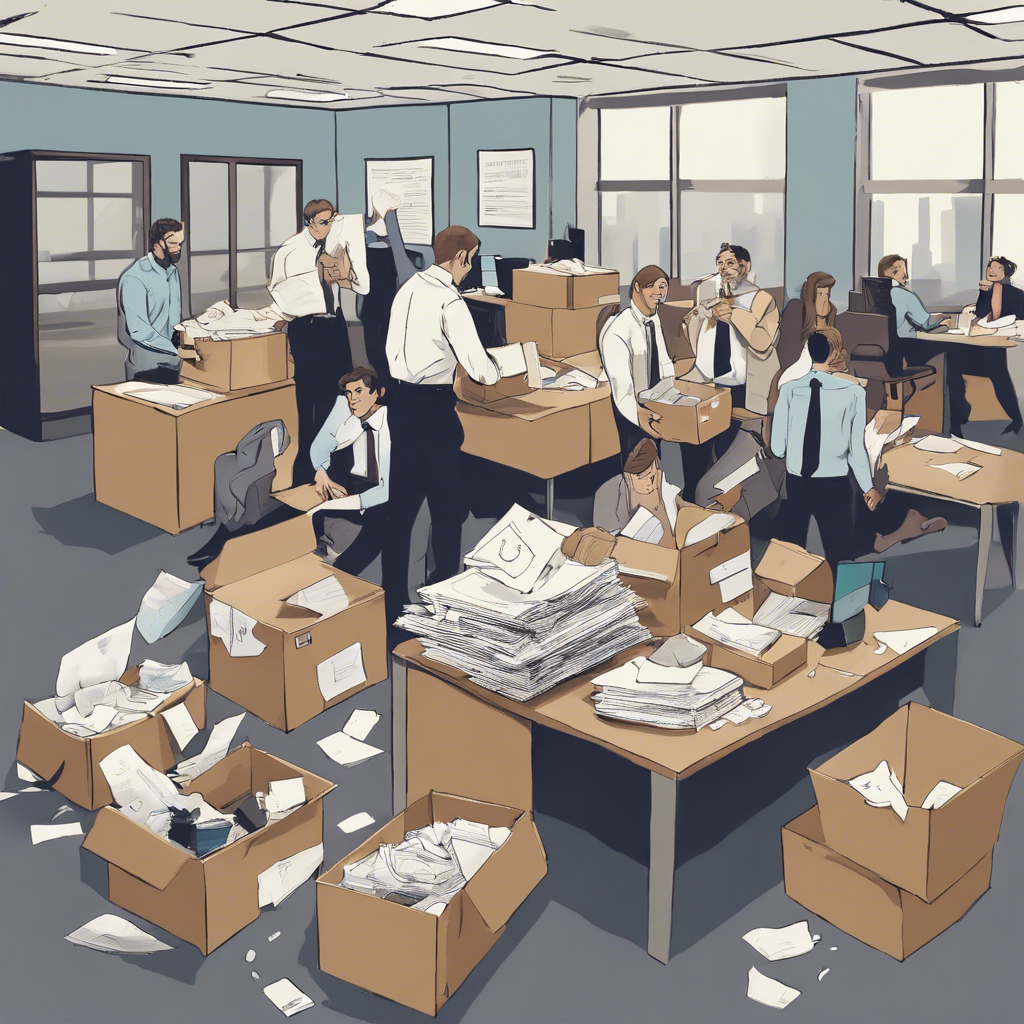

In [28]:
from IPython.display import Image
Image(filename='1.png')

In [1]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler # Yazıları Vektöre Dönüştürme
from pyspark.ml.classification import LogisticRegression # LogisticRegression import
from pyspark.ml.evaluation import BinaryClassificationEvaluator # Sonuç ikili olduğu için

## **1. Spark Oturumu Oluşturma**

In [2]:
spark = SparkSession.builder.appName('churn').getOrCreate()  # Spark oturumu oluşturma

## **2. Veri Yükleme**

In [3]:
data = spark.read.csv('/content/churn.csv', inferSchema=True, header=True)  # CSV dosyasını okuma ve Spark DataFrame'ine dönüştürme
data.printSchema() # DataFrame'nin bilgilerini ekrana yazma

root
 |-- _c0: integer (nullable = true)
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Churn: integer (nullable = true)



## **3. Özellik Mühendisliği**

In [5]:
feature_columns = [col for col in data.columns if col not in ["Names", "Churn"]] # "Names" ve "Churn" dışındaki tüm sütunları seç
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features') # Seçilen sütunları birleştirmek için VectorAssembler oluştur
data = assembler.transform(data).select('features', 'Churn') # Veriyi dönüştür ve sadece 'features' ve 'Churn' sütunlarını seç

## **4. Veri Bölme**

In [6]:
train_data, test_data = data.randomSplit([0.80,0.2], seed=42)  # Veri setini eğitim ve test olarak bölme (42 evrenin anlamı)

## **5. Model Eğitimi**

In [8]:
lr = LogisticRegression(labelCol='Churn', featuresCol='features') # Lojistik Regresyon modelini tanımla
model=lr.fit(train_data)  # Lojistik Regresyon modelini oluşturma ve eğitme

## **6. Tahmin Yapma**

In [9]:
predictions=model.transform(test_data)  # Test verisi üzerinde tahmin yapma

## **7. Model Değerlendirme**

In [14]:
evaluator = BinaryClassificationEvaluator(labelCol='Churn')
accuracy = evaluator.evaluate(predictions)
print("Accuracy: ", accuracy)

Accuracy:  1.0


In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator  # Değerlendirme metriklerini içe aktar

# Mevcut değerlendirici
binary_evaluator = BinaryClassificationEvaluator(labelCol='Churn')  # İkili sınıflandırma değerlendiricisi oluştur
auc = binary_evaluator.evaluate(predictions)  # AUC skorunu hesapla

print("\nModel Performans Metriği:")
print("-------------------------")
print(f"AUC (Area Under the Curve): {auc:.4f}")
print("  - ROC eğrisinin altında kalan alan")
print("  - Modelin farklı eşik değerlerinde pozitif ve negatif örnekleri ayırma yeteneğini ölçer")
print("  - 0.5 rastgele tahmin, 1.0 mükemmel sınıflandırma anlamına gelir")
print("  - Genellikle:")
print("    * 0.90-1.00 = Mükemmel")
print("    * 0.80-0.90 = İyi")
print("    * 0.70-0.80 = Orta")
print("    * 0.60-0.70 = Zayıf")
print("    * 0.50-0.60 = Başarısız")


Model Performans Metriği:
-------------------------
AUC (Area Under the Curve): 1.0000
  - ROC eğrisinin altında kalan alan
  - Modelin farklı eşik değerlerinde pozitif ve negatif örnekleri ayırma yeteneğini ölçer
  - 0.5 rastgele tahmin, 1.0 mükemmel sınıflandırma anlamına gelir
  - Genellikle:
    * 0.90-1.00 = Mükemmel
    * 0.80-0.90 = İyi
    * 0.70-0.80 = Orta
    * 0.60-0.70 = Zayıf
    * 0.50-0.60 = Başarısız


In [19]:
# Confusion Matrix
tp = predictions.filter((predictions.Churn == 1) & (predictions.prediction == 1)).count()  # Doğru pozitif sayısını hesapla
tn = predictions.filter((predictions.Churn == 0) & (predictions.prediction == 0)).count()  # Doğru negatif sayısını hesapla
fp = predictions.filter((predictions.Churn == 0) & (predictions.prediction == 1)).count()  # Yanlış pozitif sayısını hesapla
fn = predictions.filter((predictions.Churn == 1) & (predictions.prediction == 0)).count()  # Yanlış negatif sayısını hesapla

print("Confusion Matrix:")  # Karışıklık matrisini yazdır
print("------------------")
print(f"          Tahmin Edilen")
print(f"         Negatif Pozitif")
print(f"Gerçek  +-----------------+")
print(f"Negatif | {tn:7d} | {fp:7d} |")
print(f"Pozitif | {fn:7d} | {tp:7d} |")
print(f"        +-----------------+")

Confusion Matrix:
------------------
          Tahmin Edilen
         Negatif Pozitif
Gerçek  +-----------------+
Negatif |     122 |       0 |
Pozitif |       0 |      24 |
        +-----------------+


In [26]:
# Precision, Recall hesaplama
precision = tp / (tp + fp)  # Kesinlik (precision) hesapla
recall = tp / (tp + fn)  # Duyarlılık (recall) hesapla

print("\nModel Performans Metrikleri:")
print("-----------------------------")
print(f"Precision (Kesinlik): {precision:.4f}")
print("  - Doğru pozitif tahminlerin, tüm pozitif tahminlere oranı")
print("  - Modelin pozitif olarak tahmin ettiği örneklerin ne kadarının gerçekten pozitif olduğunu gösterir")

print(f"\nRecall (Duyarlılık): {recall:.4f}")
print("  - Doğru pozitif tahminlerin, tüm gerçek pozitif örneklere oranı")
print("  - Gerçekte pozitif olan örneklerin ne kadarının model tarafından doğru tespit edildiğini gösterir")

# F1 skoru hesaplama ve ekleme
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"\nF1 Score: {f1_score:.4f}")
print("  - Precision ve Recall'un harmonik ortalaması")
print("  - Modelin genel performansını tek bir sayıda özetler")

print("\nNot: Tüm metrikler 0 ile 1 arasındadır. Daha yüksek değerler daha iyi performansı gösterir.")

# model save
model_path = "churn_prediction_model"  # Modelin kaydedileceği dizin
model.save(model_path)  # Modeli belirtilen dizine kaydet


Model Performans Metrikleri:
-----------------------------
Precision (Kesinlik): 1.0000
  - Doğru pozitif tahminlerin, tüm pozitif tahminlere oranı
  - Modelin pozitif olarak tahmin ettiği örneklerin ne kadarının gerçekten pozitif olduğunu gösterir

Recall (Duyarlılık): 1.0000
  - Doğru pozitif tahminlerin, tüm gerçek pozitif örneklere oranı
  - Gerçekte pozitif olan örneklerin ne kadarının model tarafından doğru tespit edildiğini gösterir

F1 Score: 1.0000
  - Precision ve Recall'un harmonik ortalaması
  - Modelin genel performansını tek bir sayıda özetler

Not: Tüm metrikler 0 ile 1 arasındadır. Daha yüksek değerler daha iyi performansı gösterir.


In [27]:
if spark.sparkContext._jsc.sc().isStopped():
    print("\nSpark oturumu zaten kapalı.")
else:
    print("\nSpark oturumu kapatılıyor...")
    spark.stop()
    print("Spark oturumu başarıyla kapatıldı.")

print("\nProgram tamamlandı.")


Spark oturumu kapatılıyor...
Spark oturumu başarıyla kapatıldı.

Program tamamlandı.
